In [1]:
import os
import h5py
import numpy as np
import pandas as pd
# import anndata as ad
import scanpy as sc
import archs4py as a4

# Imports for reading expression (gene-level counts) from HDF5 (.h5 / .h5ad / 10x .h5) files
import scipy.sparse as sp

In [2]:
file = "./data/archs4/human_gene_v2.5.h5"
a4.ls(file)


data                      
│ expression            uint32 | (67186, 888821)
meta                      
│ genes                     
│   biotype               str    | (67186,)
│   ensembl_gene          str    | (67186,)
│   symbol                str    | (67186,)
│ info                      
│   author                str    | ()
│   contact               str    | ()
│   creation-date         str    | ()
│   laboratory            str    | ()
│   version               str    | ()
│ samples                   
│   channel_count         str    | (888821,)
│   characteristics_ch1   str    | (888821,)
│   contact_address       str    | (888821,)
│   contact_city          str    | (888821,)
│   contact_country       str    | (888821,)
│   contact_institute     str    | (888821,)
│   contact_name          str    | (888821,)
│   contact_zip           str    | (888821,)
│   data_processing       str    | (888821,)
│   extract_protocol_ch1  str    | (888821,)
│   geo_accession         str    | (88

In [3]:
import h5py

with h5py.File(file, "r") as f:
    print(list(f.keys()))
    print(list(f["meta"].keys())[:20])  # print first 20 metadata fields

with h5py.File(file, "r") as f:
    print(list(f["meta"]["samples"].keys()))

with h5py.File(file, "r") as f:
    print("Expression matrix shape:", f["data"]["expression"].shape)
    print("Series ID count:", len(f["meta"]["samples"]["series_id"]))



['data', 'meta']
['genes', 'info', 'samples']
['channel_count', 'characteristics_ch1', 'contact_address', 'contact_city', 'contact_country', 'contact_institute', 'contact_name', 'contact_zip', 'data_processing', 'extract_protocol_ch1', 'geo_accession', 'instrument_model', 'last_update_date', 'library_selection', 'library_source', 'library_strategy', 'molecule_ch1', 'organism_ch1', 'platform_id', 'relation', 'sample', 'series_id', 'singlecellprobability', 'source_name_ch1', 'status', 'submission_date', 'taxid_ch1', 'title', 'type']
Expression matrix shape: (67186, 888821)
Series ID count: 888821


In [4]:
import h5py, pandas as pd, numpy as np

rows = []
with h5py.File(file, "r") as f:
    samples = f["meta"]["samples"]
    for key in samples.keys():
        shape = samples[key].shape[0]
        dtype = samples[key].dtype
        # estimate number of non-empty values (for string datasets)
        try:
            data = samples[key][:1000]  # peek at first 1k entries
            non_empty = np.count_nonzero([len(x.strip()) > 0 for x in data])
            pct_non_empty = round(non_empty / len(data) * 100, 2)
        except Exception:
            pct_non_empty = "?"
        rows.append({"Field": key, "Entries": shape, "Type": str(dtype), "% non-empty (first 1k)": pct_non_empty})

df_meta_overview = pd.DataFrame(rows)
df_meta_overview.sort_values("Field", inplace=True)
df_meta_overview.head(20)


,Field,Entries,Type,% non-empty (first 1k)
0,channel_count,888821,object,100.0
1,characteristics_ch1,888821,object,100.0
2,contact_address,888821,object,100.0
3,contact_city,888821,object,100.0
4,contact_country,888821,object,100.0
5,contact_institute,888821,object,100.0
6,contact_name,888821,object,100.0
7,contact_zip,888821,object,0.0
8,data_processing,888821,object,100.0
9,extract_protocol_ch1,888821,object,100.0


In [5]:
with h5py.File(file, "r") as f:
    def decode(arr):
        return [x.decode("utf-8", "ignore") for x in arr]

    char_samples = decode(f["meta"]["samples"]["characteristics_ch1"][:10])
    src_samples = decode(f["meta"]["samples"].get("source_name_ch1", [])[:10])
    org_samples = decode(f["meta"]["samples"]["organism_ch1"][:10])

print("Characteristics examples:\n", char_samples)
print("\nSource name examples:\n", src_samples)
print("\nOrganism examples:\n", org_samples)


Characteristics examples:
 ['treatment: siNT,cell line: OCI-LY1', 'treatment: siNT,cell line: OCI-LY1', 'treatment: siNT,cell line: OCI-LY1', 'treatment: siBCL6,cell line: OCI-LY1', 'treatment: siBCL6,cell line: OCI-LY1', 'treatment: siBCL6,cell line: OCI-LY1', 'spike-in hsa-mir-147: 0.1,spike-in hsa-mir-211: 1,spike-in hsa-mir-219-5p: 10,spike-in hsa-mir-338-3p: 0.1,spike-in hsa-mir-383: 1,spike-in hsa-mir-429: 10,precursor spike-in hsa-mir-147: 0,o-methyl spike-in hsa-mir-211: 0,o-methyl spike-in hsa-mir-219-5p: 0,precursor spike-in hsa-mir-338-3p: 0,precursor spike-in hsa-mir-383: 0,o-methyl spike-in hsa-mir-429: 0', 'spike-in hsa-mir-147: 1,spike-in hsa-mir-211: 10,spike-in hsa-mir-219-5p: 0.1,spike-in hsa-mir-338-3p: 1,spike-in hsa-mir-383: 10,spike-in hsa-mir-429: 0.1,precursor spike-in hsa-mir-147: 0,o-methyl spike-in hsa-mir-211: 0,o-methyl spike-in hsa-mir-219-5p: 0,precursor spike-in hsa-mir-338-3p: 0,precursor spike-in hsa-mir-383: 0,o-methyl spike-in hsa-mir-429: 0', 'spike

In [6]:
import re
from collections import Counter

def count_keywords(strings, keywords):
    counter = Counter()
    for s in strings:
        text = s.lower()
        for k in keywords:
            if re.search(rf"\b{k}\b", text):
                counter[k] += 1
    return counter

with h5py.File(file, "r") as f:
    chars = [x.decode("utf-8", "ignore").lower() for x in f["meta"]["samples"]["characteristics_ch1"][:50000]]  # sample 50k for speed

keywords = ["breast", "lung", "colon", "liver", "brain", "kidney", "prostate", "skin", "leukemia", "cancer", "control", "normal"]
summary = count_keywords(chars, keywords)

pd.DataFrame(summary.items(), columns=["Keyword", "Approx. Sample Count"]).sort_values("Approx. Sample Count", ascending=False)


,Keyword,Approx. Sample Count
2,control,2588
1,cancer,2574
5,breast,1781
10,lung,1132
3,normal,1109
9,brain,1033
4,leukemia,929
6,prostate,619
7,liver,478
0,colon,313


In [7]:
from tqdm import tqdm

keywords = ["breast","lung","colon","liver","brain","kidney","prostate",
            "skin","leukemia","cancer","control","normal"]
counter = Counter()

with h5py.File(file, "r") as f:
    dset = f["meta"]["samples"]["characteristics_ch1"]
    chunk = 50000
    for start in tqdm(range(0, len(dset), chunk)):
        end = min(start + chunk, len(dset))
        chunk_data = [x.decode("utf-8", "ignore").lower() for x in dset[start:end]]
        for s in chunk_data:
            for k in keywords:
                if k in s:
                    counter[k] += 1

summary_full = (
    pd.DataFrame(counter.items(), columns=["Keyword", "Sample Count"])
    .sort_values("Sample Count", ascending=False)
)
summary_full


100%|██████████| 18/18 [00:02<00:00,  7.67it/s]


,Keyword,Sample Count
2,control,60378
1,cancer,55190
6,breast,22290
3,normal,20692
9,lung,19148
5,skin,17941
8,liver,15238
11,brain,14193
4,leukemia,13173
7,prostate,9789


In [8]:
import re
import pandas as pd
import h5py

cancer_terms = ["cancer", "tumor", "carcinoma", "leukemia", "lymphoma", "melanoma", "glioma"]

with h5py.File(file, "r") as f:
    chars = [x.decode("utf-8", "ignore").lower() for x in f["meta"]["samples"]["characteristics_ch1"][:]]
    if "source_name_ch1" in f["meta"]["samples"]:
        srcs = [x.decode("utf-8", "ignore").lower() for x in f["meta"]["samples"]["source_name_ch1"][:]]
    else:
        srcs = [""] * len(chars)
    geo = [x.decode("utf-8", "ignore") for x in f["meta"]["samples"]["geo_accession"][:]]

df = pd.DataFrame({
    "geo_accession": geo,
    "source_name": srcs,
    "characteristics": chars
})

pattern = re.compile(r"\b(" + "|".join(cancer_terms) + r")\b", flags=re.IGNORECASE)
mask = df["characteristics"].str.contains(pattern) | df["source_name"].str.contains(pattern)

cancer_df = df[mask]
print(f"{len(cancer_df):,} samples match cancer-related terms")
cancer_df.head(10)


C:\Users\walt\AppData\Local\Temp\ipykernel_16872\2018265277.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["characteristics"].str.contains(pattern) | df["source_name"].str.contains(pattern)


164,982 samples match cancer-related terms


,geo_accession,source_name,characteristics
30,GSM1013480,myeloid leukemia,"cell line: hl60,rna fraction: total rna"
31,GSM1013481,myeloid leukemia,"cell line: hl60,rna fraction: non-polyadenylat..."
32,GSM1019735,ht29 treated with 0 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
33,GSM1019736,ht29 treated with 0 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
34,GSM1019737,ht29 treated with 0 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
35,GSM1019738,ht29 treated with 5 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
36,GSM1019739,ht29 treated with 5 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
37,GSM1019740,ht29 treated with 5 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
38,GSM1019741,ht29 treated with 10 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."
39,GSM1019742,ht29 treated with 10 î¼m of 5-aza,"cell line: ht29,cell type: colon cancer,treatm..."


In [9]:
# import h5py, random

# file = "./data/archs4/human_gene_v2.5.h5"

# with h5py.File(file, "r") as f:
#     chars = [x.decode("utf-8", "ignore") for x in f["meta"]["samples"]["characteristics_ch1"][:]]

# # pick random samples
# for s in random.sample(chars, 10):
#     print(s)


In [10]:
print(cancer_df.shape)
print(cancer_df["characteristics"].iloc[0])

(164982, 3)
cell line: hl60,rna fraction: total rna


Total samples: 888821


C:\Users\walt\AppData\Local\Temp\ipykernel_16872\2131407054.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["chars"].str.contains(pattern) | df["src"].str.contains(pattern)


Cancer samples found: 164982


100%|██████████| 1000/1000 [00:05<00:00, 178.50it/s]



Expression shape: (67186, 1000)
After aggregation: (62548, 1000)
After aggregation: (62548, 1000)


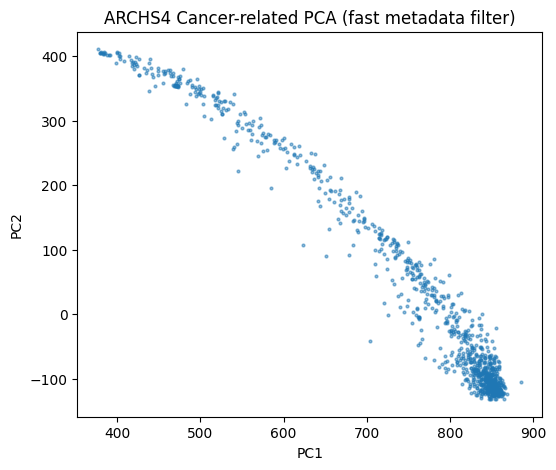

In [11]:
import h5py, re, pandas as pd, archs4py as a4
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

file = "./data/archs4/human_gene_v2.5.h5"

# 1️⃣ Load metadata once
with h5py.File(file, "r") as f:
    chars = [x.decode("utf-8", "ignore").lower() for x in f["meta"]["samples"]["characteristics_ch1"][:]]
    srcs  = [x.decode("utf-8", "ignore").lower() for x in f["meta"]["samples"]["source_name_ch1"][:]]
    geo   = [x.decode("utf-8", "ignore") for x in f["meta"]["samples"]["geo_accession"][:]]

df = pd.DataFrame({"geo": geo, "src": srcs, "chars": chars})
print("Total samples:", len(df))

# 2️⃣ Fast regex filter for cancer terms
pattern = re.compile(r"\b(cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma)\b")
mask = df["chars"].str.contains(pattern) | df["src"].str.contains(pattern)
cancer_df = df[mask]
print("Cancer samples found:", len(cancer_df))

# optional: downsample for quick PCA
geo_subset = cancer_df["geo"].sample(1000, random_state=42).tolist()

# 3️⃣ Extract expression data just once
expr = a4.data.samples(file, geo_subset)
print("Expression shape:", expr.shape)

# 4️⃣ Normalize + aggregate
expr_norm = a4.normalize(expr, method="log_quantile")
expr_agg  = a4.utils.aggregate_duplicate_genes(expr_norm)
print("After aggregation:", expr_agg.shape)

# 5️⃣ Run PCA
X = expr_agg.T.apply(pd.to_numeric, errors="coerce").fillna(0)
X = X.loc[:, (X != 0).any(axis=0)]

pca = TruncatedSVD(n_components=2, random_state=42)
pcs = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(pcs[:,0], pcs[:,1], s=4, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ARCHS4 Cancer-related PCA (fast metadata filter)")
plt.show()


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]



Total cancer samples in metadata: 179,216


100%|██████████| 1000/1000 [00:05<00:00, 184.09it/s]



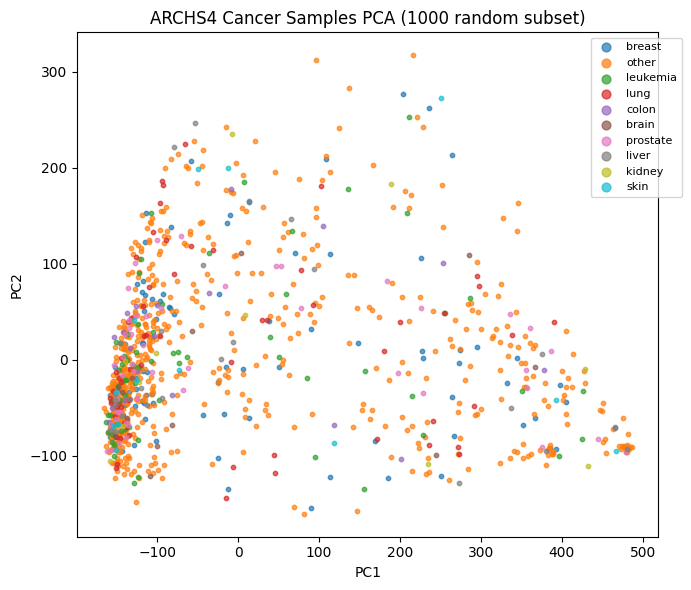

In [13]:
import re, pandas as pd, archs4py as a4
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

file = "./data/archs4/human_gene_v2.5.h5"

# ---- 1️⃣ find cancer-related samples ----
cancer_terms = r"cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma"
meta = a4.meta.meta(file, cancer_terms,
                    meta_fields=["geo_accession", "characteristics_ch1", "source_name_ch1"])
geo_ids = meta["geo_accession"].tolist()
print(f"Total cancer samples in metadata: {len(geo_ids):,}")

# ---- 2️⃣ subset for PCA ----
subset_size = 1000
meta_sample = meta.sample(subset_size, random_state=42).reset_index(drop=True)
geo_subset = meta_sample["geo_accession"].tolist()

# quick keyword label
def assign_label(text):
    text = str(text).lower()
    for k in ["breast","lung","liver","skin","brain","kidney","colon","leukemia","prostate"]:
        if k in text:
            return k
    return "other"

meta_sample["label"] = meta_sample["characteristics_ch1"].apply(assign_label)

# ---- 3️⃣ extract + normalize ----
expr = a4.data.samples(file, geo_subset)
expr_norm = a4.normalize(expr, method="log_quantile")

# ---- 4️⃣ PCA ----
X = expr_norm.T.apply(pd.to_numeric, errors="coerce").fillna(0)
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X)

# ---- 5️⃣ plot ----
plt.figure(figsize=(7,6))
palette = dict(zip(meta_sample["label"].unique(),
                   sns.color_palette("tab10", len(meta_sample["label"].unique()))))

for label, color in palette.items():
    idx = meta_sample["label"] == label
    plt.scatter(pcs[idx,0], pcs[idx,1], s=10, alpha=0.7, label=label, color=color)

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("ARCHS4 Cancer Samples PCA (1000 random subset)")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


Loading metadata...


100%|██████████| 3/3 [00:08<00:00,  2.95s/it]



breast    : 150 samples
lung      : 150 samples
liver     : 150 samples
skin      : 150 samples
brain     : 150 samples
skin      : 150 samples
brain     : 150 samples
kidney    : 150 samples
colon     : 150 samples
leukemia  : 150 samples
prostate  : 150 samples

Total samples selected: 1350

🔹 Processing breast (150 samples)...
kidney    : 150 samples
colon     : 150 samples
leukemia  : 150 samples
prostate  : 150 samples

Total samples selected: 1350

🔹 Processing breast (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 48.66it/s]



  → After filtering: 58 genes, 150 samples

🔹 Processing lung (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 48.11it/s]



  → After filtering: 48 genes, 150 samples

🔹 Processing liver (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 43.70it/s]



  → After filtering: 75 genes, 150 samples

🔹 Processing skin (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 43.92it/s]



  → After filtering: 48 genes, 150 samples

🔹 Processing brain (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 44.49it/s]



  → After filtering: 16 genes, 150 samples

🔹 Processing kidney (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 46.32it/s]



  → After filtering: 28 genes, 150 samples

🔹 Processing colon (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 49.36it/s]



  → After filtering: 55 genes, 150 samples

🔹 Processing leukemia (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 48.62it/s]



  → After filtering: 35 genes, 150 samples

🔹 Processing prostate (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 50.54it/s]



  → After filtering: 46 genes, 150 samples

Aligning gene sets across all cancer types...
Final aligned matrix: (101, 1350)
Running PCA on matrix: (1350, 101)


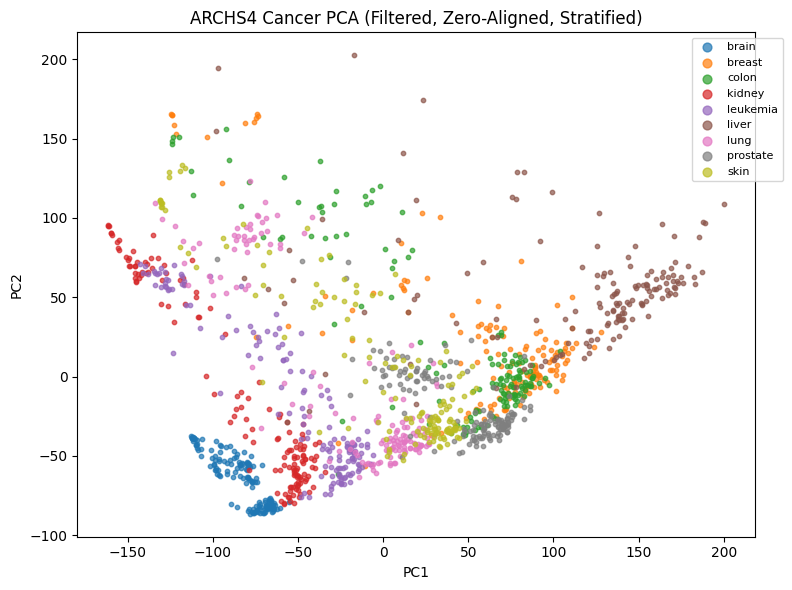

In [12]:
import re, pandas as pd, numpy as np, archs4py as a4
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------
file = "./data/archs4/human_gene_v2.5.h5"
sample_per_type = 150   # adjust based on available RAM
readThreshold = 50
sampleThreshold = 0.02

# -------------------------------------------------------------
# 1️⃣  LOAD METADATA
# -------------------------------------------------------------
print("Loading metadata...")
meta = a4.meta.meta(
    file,
    "cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma",
    meta_fields=["geo_accession", "characteristics_ch1", "source_name_ch1"]
)
meta["text"] = (meta["characteristics_ch1"].fillna("") + " " +
                meta["source_name_ch1"].fillna("")).str.lower()

# -------------------------------------------------------------
# 2️⃣  DEFINE CANCER TYPES & STRATIFIED SAMPLING
# -------------------------------------------------------------
cancer_types = {
    "breast": r"breast",
    "lung": r"lung",
    "liver": r"liver",
    "skin": r"skin|melanoma",
    "brain": r"brain|glioma",
    "kidney": r"kidney|renal",
    "colon": r"colon|colorectal",
    "leukemia": r"leukemia",
    "prostate": r"prostate",
}

subset_geo, subset_labels = [], []

for label, pattern in cancer_types.items():
    mask = meta["text"].str.contains(pattern, na=False)
    ids = meta.loc[mask, "geo_accession"]
    if len(ids) == 0:
        print(f"⚠️  No matches found for {label}")
        continue
    chosen = ids.sample(min(sample_per_type, len(ids)), random_state=42)
    subset_geo.extend(chosen.tolist())
    subset_labels.extend([label]*len(chosen))
    print(f"{label:10s}: {len(chosen)} samples")

subset_df = pd.DataFrame({"geo": subset_geo, "label": subset_labels})
print("\nTotal samples selected:", subset_df.shape[0])

# -------------------------------------------------------------
# 3️⃣  EXTRACT, NORMALIZE, FILTER, AGGREGATE (PER TYPE)
# -------------------------------------------------------------
expr_by_type = {}

for label in subset_df["label"].unique():
    geo_list = subset_df.loc[subset_df["label"] == label, "geo"].tolist()
    print(f"\n🔹 Processing {label} ({len(geo_list)} samples)...")

    expr = a4.data.samples(file, geo_list)
    expr_norm = a4.normalize(expr, method="log_quantile")

    filtered = a4.utils.filter_genes(
        expr_norm,
        readThreshold=readThreshold,
        sampleThreshold=sampleThreshold,
        deterministic=True,
        aggregate=True
    )
    expr_by_type[label] = filtered
    print(f"  → After filtering: {filtered.shape[0]} genes, {filtered.shape[1]} samples")

# -------------------------------------------------------------
# 4️⃣  ALIGN ALL GENE SETS (ADD ZERO COLUMNS WHERE MISSING)
# -------------------------------------------------------------
print("\nAligning gene sets across all cancer types...")
all_genes = sorted(set().union(*[df.index for df in expr_by_type.values()]))
aligned_exprs = []

for label, df in expr_by_type.items():
    aligned = df.reindex(all_genes, fill_value=0)
    aligned_exprs.append(aligned)

# Concatenate all aligned matrices horizontally
expr_final = pd.concat(aligned_exprs, axis=1)
print("Final aligned matrix:", expr_final.shape)

# Rebuild matching label list (for PCA color mapping)
label_order = []
for label, df in expr_by_type.items():
    label_order.extend([label] * df.shape[1])
label_order = np.array(label_order)

# -------------------------------------------------------------
# 5️⃣  PCA
# -------------------------------------------------------------
X = expr_final.T.apply(pd.to_numeric, errors="coerce").fillna(0)
print("Running PCA on matrix:", X.shape)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X)

# -------------------------------------------------------------
# 6️⃣  VISUALIZATION
# -------------------------------------------------------------
plt.figure(figsize=(8,6))
palette = dict(zip(sorted(expr_by_type.keys()),
                   sns.color_palette("tab10", len(expr_by_type))))

for label, color in palette.items():
    idx = (label_order == label)
    plt.scatter(pcs[idx,0], pcs[idx,1], s=10, alpha=0.7, label=label, color=color)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ARCHS4 Cancer PCA (Filtered, Zero-Aligned, Stratified)")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


In [14]:
# --- sanity check: names of genes and samples ---

print("\n🔍 Gene index preview:")
print(expr_final.index[:10].tolist())  # first 10 gene names

print("\n🔍 Sample (GEO accession) column names preview:")
print(expr_final.columns[:10].tolist())  # first 10 sample IDs

print("\nMatrix dimensions:", expr_final.shape)



🔍 Gene index preview:
['ABCF1', 'AGER', 'AGPAT1', 'AIF1', 'APOM', 'ATAT1', 'ATP6V1G2', 'BAG6', 'BRD2', 'C2']

🔍 Sample (GEO accession) column names preview:
['GSM1401743', 'GSM1620578', 'GSM1700778', 'GSM1942108', 'GSM1963818', 'GSM1963859', 'GSM2098659', 'GSM2124715', 'GSM2333037', 'GSM2392123']

Matrix dimensions: (101, 1350)


In [15]:
summary_df = pd.DataFrame({
    "gene_count": [len(expr_final.index)],
    "sample_count": [len(expr_final.columns)],
    "first_genes": [", ".join(expr_final.index[:5])],
    "first_samples": [", ".join(expr_final.columns[:5])]
})
display(summary_df)


,gene_count,sample_count,first_genes,first_samples
0,101,1350,"ABCF1, AGER, AGPAT1, AIF1, APOM","GSM1401743, GSM1620578, GSM1700778, GSM1942108..."


In [1]:
from Bio import SeqIO
import pandas as pd

protein_sequence_file = "./data/ensembl/Homo_sapiens.GRCh38.pep.all.fa"

records = []
for rec in SeqIO.parse(protein_sequence_file, "fasta"):
    desc = rec.description
    # only split the first ":" to avoid breaking on values with colons
    parts = {}
    for token in desc.split():
        if ":" in token:
            k, v = token.split(":", 1)
            parts[k] = v
    # Keep only true protein-coding genes
    if parts.get("gene_biotype") != "protein_coding":
        continue
    records.append({
        "gene_id": parts.get("gene"),
        "gene_symbol": parts.get("gene_symbol"),
        "seq": str(rec.seq)
    })

df = pd.DataFrame(records)
df = df.drop_duplicates("gene_symbol")
print("✅ Protein-coding genes extracted:", df.shape)
print(df.head())


✅ Protein-coding genes extracted: (19478, 3)
             gene_id gene_symbol  \
0  ENSG00000198888.2      MT-ND1   
1  ENSG00000198763.3      MT-ND2   
2  ENSG00000198804.2      MT-CO1   
3  ENSG00000198712.1      MT-CO2   
4  ENSG00000228253.1     MT-ATP8   

                                                 seq  
0  MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLL...  
1  MNPLAQPVIYSTIFAGTLITALSSHWFFTWVGLEMNMLAFIPVLTK...  
2  MFADRWLFSTNHKDIGTLYLLFGAWAGVLGTALSLLIRAELGQPGN...  
3  MAHAAQVGLQDATSPIMEELITFHDHALMIIFLICFLVLYALFLTL...  
4  MPQLNTTVWPTMITPMLLTLFLITQLKMLNTNYHLPPSPKPMKMKN...  


In [2]:
import pandas as pd

# Assuming these are defined:
# expr_final → your expression matrix (genes × samples)
# df → your protein-coding gene DataFrame (from Ensembl)

expr_genes = pd.Index(expr_final.index)
protein_genes = pd.Index(df["gene_symbol"])

# Intersect
shared_genes = expr_genes.intersection(protein_genes)

print("Total genes in expression data:", len(expr_genes))
print("Protein-coding genes in Ensembl:", len(protein_genes))
print("Overlapping genes:", len(shared_genes))
print(f"Coverage: {len(shared_genes) / len(expr_genes) * 100:.2f}% of expression genes are protein-coding")

# Optional — see a few examples
print("\nExample overlapping genes:", shared_genes[:10].tolist())


NameError: name 'expr_final' is not defined

In [3]:
import h5py
import pandas as pd

file = "./data/archs4/human_gene_v2.5.h5"

with h5py.File(file, "r") as f:
    n_genes, n_samples = f["data"]["expression"].shape
    print(f"ARCHS4 Expression matrix: {n_genes:,} genes × {n_samples:,} samples")

# Load all gene symbols (this is just metadata, not expression values)
with h5py.File(file, "r") as f:
    genes = [g.decode("utf-8") for g in f["meta"]["genes"]["symbol"][:]]

expr_genes = pd.Index(genes)
protein_genes = pd.Index(df["gene_symbol"])  # from Ensembl
shared_genes = expr_genes.intersection(protein_genes)

print("Total genes in full ARCHS4:", len(expr_genes))
print("Protein-coding genes in Ensembl:", len(protein_genes))
print("Overlapping genes:", len(shared_genes))
print(f"Coverage: {len(shared_genes) / len(expr_genes) * 100:.2f}% overlap")
print("\nExample overlapping genes:", shared_genes[:10].tolist())

ARCHS4 Expression matrix: 67,186 genes × 888,821 samples
Total genes in full ARCHS4: 67186
Protein-coding genes in Ensembl: 19478
Overlapping genes: 19243
Coverage: 28.64% overlap

Example overlapping genes: ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA', 'STPG1']


In [4]:
# Create filetered geene list (protein-coding only)
protein_genes_shared = list(shared_genes)
print(f"Retaining {len(protein_genes_shared):,} protein-coding genes from ARCHS4")


Retaining 19,243 protein-coding genes from ARCHS4


In [5]:
# Save both the gene and sample lists to disk
import pandas as pd

# Save shared protein-coding genes
pd.Series(protein_genes_shared, name="gene_symbol").to_csv("./data/archs4/protein_coding_genes.txt", index=False)

# Save list of all sample IDs for reference
with h5py.File(file, "r") as f:
    all_samples = [s.decode("utf-8") for s in f["meta"]["samples"]["geo_accession"][:]]
pd.Series(all_samples, name="geo_accession").to_csv("./data/archs4/all_samples.txt", index=False)

print("✅ Saved protein_coding_genes.txt and all_samples.txt")


✅ Saved protein_coding_genes.txt and all_samples.txt


In [9]:
#Manual duplication cleaning for later

# import h5py
# import pandas as pd
# import numpy as np

# file = "./data/archs4/human_gene_v2.5.h5"
# keyword = "cancer"

# # Load gene names once
# with h5py.File(file, "r") as f:
#     genes = [g.decode("utf-8") for g in f["meta"]["genes"]["symbol"][:]]

# # Extract subset (already large)
# expr = a4.data.meta(file, keyword, remove_sc=True)
# print("Subset matrix:", expr.shape)

# # Instead of groupby (too big), do manual aggregation:
# print("⚙️ Aggregating duplicates safely...")
# unique_genes = sorted(set(expr.index))
# agg = pd.DataFrame(index=unique_genes, columns=expr.columns, dtype=np.float32)

# for gene in unique_genes:
#     dup_rows = expr.loc[gene]
#     if isinstance(dup_rows, pd.Series):
#         agg.loc[gene] = dup_rows.values
#     else:
#         agg.loc[gene] = dup_rows.sum(axis=0).values

# agg.to_hdf(f"./data/archs4/{keyword}_agg_safe.h5", key="expr", mode="w")
# print("✅ Saved aggregated matrix")


Loading metadata...


100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


breast    : 150 samples
lung      : 150 samples
liver     : 150 samples
skin      : 150 samples
brain     : 150 samples
kidney    : 150 samples
colon     : 150 samples
leukemia  : 150 samples
prostate  : 150 samples

Total samples selected: 1350

🔹 Processing breast (150 samples)...


100%|██████████| 150/150 [00:03<00:00, 48.81it/s]


  → After filtering: 58 genes, 150 samples

🔹 Processing lung (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 51.45it/s]


  → After filtering: 48 genes, 150 samples

🔹 Processing liver (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 51.60it/s]


  → After filtering: 75 genes, 150 samples

🔹 Processing skin (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 52.34it/s]


  → After filtering: 48 genes, 150 samples

🔹 Processing brain (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 53.76it/s]


  → After filtering: 16 genes, 150 samples

🔹 Processing kidney (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 53.32it/s]


  → After filtering: 28 genes, 150 samples

🔹 Processing colon (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 53.95it/s]


  → After filtering: 55 genes, 150 samples

🔹 Processing leukemia (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 54.64it/s]


  → After filtering: 35 genes, 150 samples

🔹 Processing prostate (150 samples)...


100%|██████████| 150/150 [00:02<00:00, 53.81it/s]


  → After filtering: 46 genes, 150 samples

Aligning gene sets across all cancer types...
Final aligned matrix: (101, 1350)
Running PCA on matrix: (1350, 101)


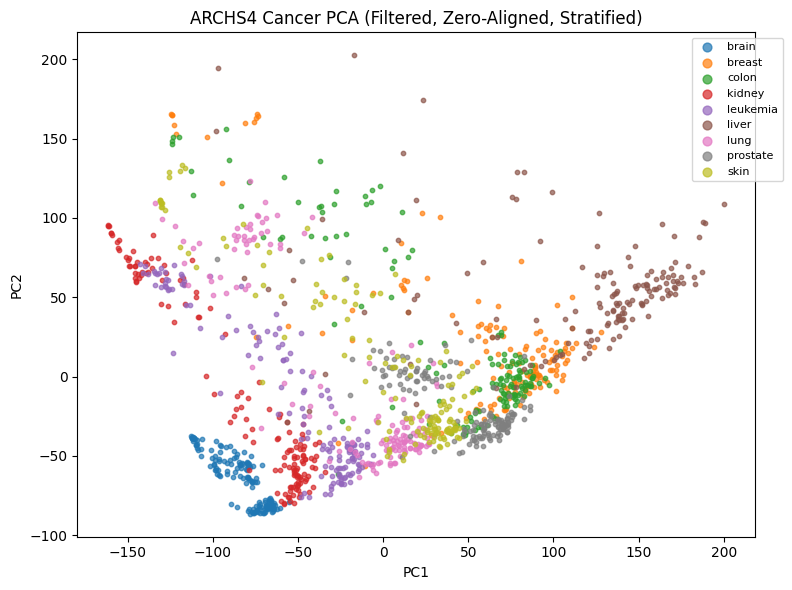

In [23]:
import re, pandas as pd, numpy as np, archs4py as a4
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------
file = "./data/archs4/human_gene_v2.5.h5"
sample_per_type = 150   # adjust based on available RAM
readThreshold = 50
sampleThreshold = 0.02

# -------------------------------------------------------------
# 1️⃣  LOAD METADATA
# -------------------------------------------------------------
print("Loading metadata...")
meta = a4.meta.meta(
    file,
    "cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma",
    meta_fields=["geo_accession", "characteristics_ch1", "source_name_ch1"]
)
meta["text"] = (meta["characteristics_ch1"].fillna("") + " " +
                meta["source_name_ch1"].fillna("")).str.lower()

# -------------------------------------------------------------
# 2️⃣  DEFINE CANCER TYPES & STRATIFIED SAMPLING
# -------------------------------------------------------------
cancer_types = {
    "breast": r"breast",
    "lung": r"lung",
    "liver": r"liver",
    "skin": r"skin|melanoma",
    "brain": r"brain|glioma",
    "kidney": r"kidney|renal",
    "colon": r"colon|colorectal",
    "leukemia": r"leukemia",
    "prostate": r"prostate",
}

subset_geo, subset_labels = [], []

for label, pattern in cancer_types.items():
    mask = meta["text"].str.contains(pattern, na=False)
    ids = meta.loc[mask, "geo_accession"]
    if len(ids) == 0:
        print(f"⚠️  No matches found for {label}")
        continue
    chosen = ids.sample(min(sample_per_type, len(ids)), random_state=42)
    subset_geo.extend(chosen.tolist())
    subset_labels.extend([label]*len(chosen))
    print(f"{label:10s}: {len(chosen)} samples")

subset_df = pd.DataFrame({"geo": subset_geo, "label": subset_labels})
print("\nTotal samples selected:", subset_df.shape[0])

# -------------------------------------------------------------
# 3️⃣  EXTRACT, NORMALIZE, FILTER, AGGREGATE (PER TYPE)
# -------------------------------------------------------------
expr_by_type = {}

for label in subset_df["label"].unique():
    geo_list = subset_df.loc[subset_df["label"] == label, "geo"].tolist()
    print(f"\n🔹 Processing {label} ({len(geo_list)} samples)...")

    expr = a4.data.samples(file, geo_list)
    expr_norm = a4.normalize(expr, method="log_quantile")

    filtered = a4.utils.filter_genes(
        expr_norm,
        readThreshold=readThreshold,
        sampleThreshold=sampleThreshold,
        deterministic=True,
        aggregate=True
    )
    expr_by_type[label] = filtered
    print(f"  → After filtering: {filtered.shape[0]} genes, {filtered.shape[1]} samples")

# -------------------------------------------------------------
# 4️⃣  ALIGN ALL GENE SETS (ADD ZERO COLUMNS WHERE MISSING)
# -------------------------------------------------------------
print("\nAligning gene sets across all cancer types...")
all_genes = sorted(set().union(*[df.index for df in expr_by_type.values()]))
aligned_exprs = []

for label, df in expr_by_type.items():
    aligned = df.reindex(all_genes, fill_value=0)
    aligned_exprs.append(aligned)

# Concatenate all aligned matrices horizontally
expr_final = pd.concat(aligned_exprs, axis=1)
print("Final aligned matrix:", expr_final.shape)

# Rebuild matching label list (for PCA color mapping)
label_order = []
for label, df in expr_by_type.items():
    label_order.extend([label] * df.shape[1])
label_order = np.array(label_order)

# -------------------------------------------------------------
# 5️⃣  PCA
# -------------------------------------------------------------
X = expr_final.T.apply(pd.to_numeric, errors="coerce").fillna(0)
print("Running PCA on matrix:", X.shape)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X)

# -------------------------------------------------------------
# 6️⃣  VISUALIZATION
# -------------------------------------------------------------
plt.figure(figsize=(8,6))
palette = dict(zip(sorted(expr_by_type.keys()),
                   sns.color_palette("tab10", len(expr_by_type))))

for label, color in palette.items():
    idx = (label_order == label)
    plt.scatter(pcs[idx,0], pcs[idx,1], s=10, alpha=0.7, label=label, color=color)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ARCHS4 Cancer PCA (Filtered, Zero-Aligned, Stratified)")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


Running t-SNE on PCA-reduced data...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1350 samples in 0.000s...
[t-SNE] Computed neighbors for 1350 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1350
[t-SNE] Computed conditional probabilities for sample 1350 / 1350
[t-SNE] Mean sigma: 35.085374
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.502644
[t-SNE] KL divergence after 1000 iterations: 0.396691


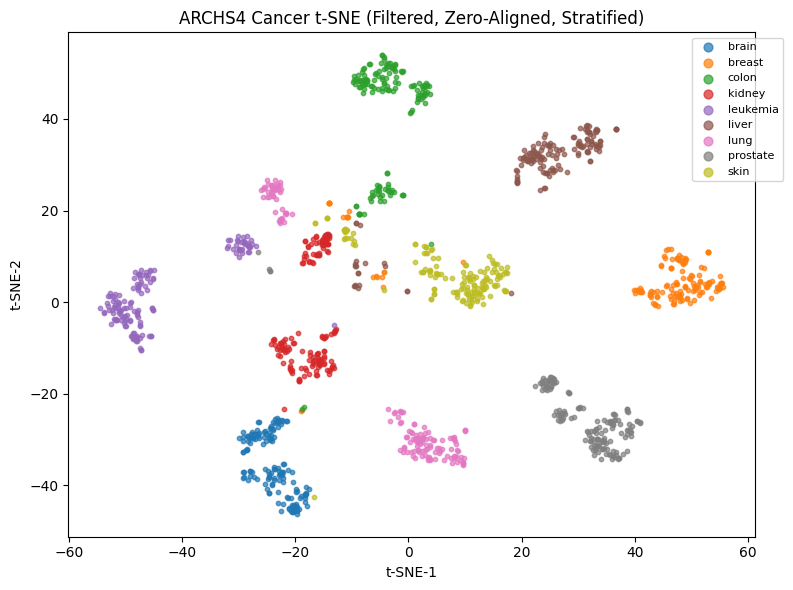

In [24]:
# -------------------------------------------------------------
# 7️⃣  t-SNE (Nonlinear embedding)
# -------------------------------------------------------------
from sklearn.manifold import TSNE

# Optional: reduce to 50 PCs first (makes t-SNE faster & denoised)
pca_50 = PCA(n_components=50, random_state=42)
X_pca = pca_50.fit_transform(X)

print("Running t-SNE on PCA-reduced data...")
tsne = TSNE(
    n_components=2,
    perplexity=30,      # neighborhood size; adjust 20–50 as needed
    learning_rate=200,  # step size
    max_iter=1000,      # number of iterations (renamed from n_iter)
    init="pca",
    random_state=42,
    verbose=1
)
X_tsne = tsne.fit_transform(X_pca)

# -------------------------------------------------------------
# 8️⃣  VISUALIZATION (t-SNE)
# -------------------------------------------------------------
plt.figure(figsize=(8,6))
for label, color in palette.items():
    idx = (label_order == label)
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=10, alpha=0.7, label=label, color=color)

plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.title("ARCHS4 Cancer t-SNE (Filtered, Zero-Aligned, Stratified)")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


In [25]:
print("\nPer-cancer-type gene counts:")
for label, df in expr_by_type.items():
    print(f"  {label:10s}: {df.shape[0]:,} genes × {df.shape[1]:,} samples")

print(f"\nTotal samples loaded: {sum(df.shape[1] for df in expr_by_type.values()):,}")
print(f"Unique genes after alignment: {len(all_genes):,}")



Per-cancer-type gene counts:
  breast    : 58 genes × 150 samples
  lung      : 48 genes × 150 samples
  liver     : 75 genes × 150 samples
  skin      : 48 genes × 150 samples
  brain     : 16 genes × 150 samples
  kidney    : 28 genes × 150 samples
  colon     : 55 genes × 150 samples
  leukemia  : 35 genes × 150 samples
  prostate  : 46 genes × 150 samples

Total samples loaded: 1,350
Unique genes after alignment: 101


In [15]:
import os, re, gc, h5py, numpy as np, pandas as pd
from Bio import SeqIO
import archs4py as a4

# -------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------
file = "./data/archs4/human_gene_v2.5.h5"
protein_sequence_file = "./data/ensembl/Homo_sapiens.GRCh38.pep.all.fa"
output_h5 = "./data/archs4/cancer_subset_prebulk_tpm.h5"
output_dir = "./data/archs4/"
os.makedirs(output_dir, exist_ok=True)

sample_per_type = 120      # ~8 types × 120 ≈ 960 total
qc_min_nonzero = 14000
canonical_gene_count = 20010

# -------------------------------------------------------------
# 1️⃣ LOAD PROTEIN-CODING GENE ANNOTATIONS
# -------------------------------------------------------------
print("📘 Parsing Ensembl FASTA for protein-coding genes...")
records = []
for rec in SeqIO.parse(protein_sequence_file, "fasta"):
    desc = rec.description
    parts = {}
    for token in desc.split():
        if ":" in token:
            k, v = token.split(":", 1)
            parts[k] = v
    if parts.get("gene_biotype") != "protein_coding":
        continue
    records.append({
        "gene_symbol": parts.get("gene_symbol"),
        "length": len(rec.seq)
    })

genes_df = pd.DataFrame(records).drop_duplicates("gene_symbol")
gene_lengths = genes_df.set_index("gene_symbol")["length"]
print(f"✅ Loaded {len(genes_df):,} protein-coding genes")

# -------------------------------------------------------------
# 2️⃣ LOAD METADATA & STRATIFY BY CANCER TYPE
# -------------------------------------------------------------
print("\n📄 Loading metadata for stratified sampling...")
meta = a4.meta.meta(
    file,
    "cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma",
    meta_fields=["geo_accession", "characteristics_ch1", "source_name_ch1"]
)
meta["text"] = (meta["characteristics_ch1"].fillna("") + " " +
                meta["source_name_ch1"].fillna("")).str.lower()

cancer_types = {
    "breast": r"breast",
    "lung": r"lung",
    "liver": r"liver",
    "skin": r"skin|melanoma",
    "brain": r"brain|glioma",
    "kidney": r"kidney|renal",
    "colon": r"colon|colorectal",
    "leukemia": r"leukemia",
    "prostate": r"prostate",
}

subset_geo, subset_labels = [], []
for label, pattern in cancer_types.items():
    ids = meta.loc[meta["text"].str.contains(pattern, na=False), "geo_accession"]
    if ids.empty:
        print(f"⚠️ No matches for {label}")
        continue
    chosen = ids.sample(min(sample_per_type, len(ids)), random_state=42)
    subset_geo.extend(chosen.tolist())
    subset_labels.extend([label]*len(chosen))
    print(f"{label:10s}: {len(chosen)}")

subset_df = pd.DataFrame({"geo": subset_geo, "label": subset_labels})
print(f"\n✅ Total selected: {len(subset_df):,} samples")

# -------------------------------------------------------------
# 3️⃣ LOAD EXPRESSION DATA (STRATIFIED SUBSET)
# -------------------------------------------------------------
print("\n📊 Loading expression data for selected samples...")
expr = a4.data.samples(file, subset_df["geo"].tolist())
print(f"Raw matrix shape: {expr.shape[0]:,} genes × {expr.shape[1]:,} samples")

# -------------------------------------------------------------
# 4️⃣ AGGREGATE DUPLICATE GENE SYMBOLS
# -------------------------------------------------------------
expr = expr.groupby(expr.index).sum()
print(f"Unique genes after aggregation: {expr.shape[0]:,}")

# -------------------------------------------------------------
# 5️⃣ FILTER TO PROTEIN-CODING GENES ONLY
# -------------------------------------------------------------
expr_pc = expr.loc[expr.index.intersection(gene_lengths.index)]
print(f"Protein-coding subset: {expr_pc.shape[0]:,} genes")

del expr
gc.collect()

# -------------------------------------------------------------
# 6️⃣ QUALITY CONTROL
# -------------------------------------------------------------
nonzero_counts = (expr_pc > 0).sum(axis=0)
expr_qc = expr_pc.loc[:, nonzero_counts >= qc_min_nonzero]
print(f"Samples passing QC: {expr_qc.shape[1]:,}/{expr_pc.shape[1]:,}")

# -------------------------------------------------------------
# 7️⃣ TPM NORMALIZATION
# -------------------------------------------------------------
print("⚙️ Normalizing counts → TPM ...")
lengths = gene_lengths.loc[expr_qc.index].fillna(1)

def counts_to_tpm(counts: pd.DataFrame, lengths: pd.Series) -> pd.DataFrame:
    rate = counts.div(lengths, axis=0)
    denom = rate.sum(axis=0)
    return rate.div(denom, axis=1) * 1e6

expr_tpm = counts_to_tpm(expr_qc, lengths)
print(f"TPM matrix: {expr_tpm.shape}")

del expr_pc, expr_qc
gc.collect()

# -------------------------------------------------------------
# 8️⃣ ALIGN TO CANONICAL GENE LIST (ZERO-PADDING)
# -------------------------------------------------------------
canonical_genes = genes_df["gene_symbol"].tolist()
expr_final = expr_tpm.reindex(canonical_genes, fill_value=0)
print(f"Aligned to canonical {len(canonical_genes):,} genes → shape {expr_final.shape}")

# -------------------------------------------------------------
# 9️⃣ SAVE FINAL DATASET
# -------------------------------------------------------------
expr_final.to_hdf(output_h5, key="expr", mode="w")
subset_df.to_csv(os.path.join(output_dir, "cancer_subset_samples.csv"), index=False)
pd.Series(canonical_genes, name="gene_symbol").to_csv(
    os.path.join(output_dir, "canonical_genes.txt"), index=False
)

print("\n✅ Stratified PreBULK subset complete!")
print(f"→ Saved {expr_final.shape[0]:,} genes × {expr_final.shape[1]:,} samples")


📘 Parsing Ensembl FASTA for protein-coding genes...
✅ Loaded 19,478 protein-coding genes

📄 Loading metadata for stratified sampling...


100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


breast    : 120
lung      : 120
liver     : 120
skin      : 120
brain     : 120
kidney    : 120
colon     : 120
leukemia  : 120
prostate  : 120

✅ Total selected: 1,080 samples

📊 Loading expression data for selected samples...


100%|██████████| 1080/1080 [00:06<00:00, 171.24it/s]


Raw matrix shape: 67,186 genes × 1,080 samples
Unique genes after aggregation: 62,548
Protein-coding subset: 19,243 genes
Samples passing QC: 641/1,080
⚙️ Normalizing counts → TPM ...
TPM matrix: (19243, 641)
Aligned to canonical 19,478 genes → shape (19478, 641)

✅ Stratified PreBULK subset complete!
→ Saved 19,478 genes × 641 samples


C:\Users\walt\AppData\Local\Temp\ipykernel_23940\2583139183.py:135: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis1] [items->None]

  expr_final.to_hdf(output_h5, key="expr", mode="w")


✅ Loaded TPM matrix: 19,478 genes × 641 samples
Sample label counts:
 label
breast      120
lung        120
liver       120
skin        120
brain       120
kidney      120
colon       120
leukemia    120
prostate    120
Name: count, dtype: int64
Aligned: 641 samples remain after matching metadata.
PCA input shape: (641, 19478)
Explained variance ratio: [0.12064377 0.05706895]


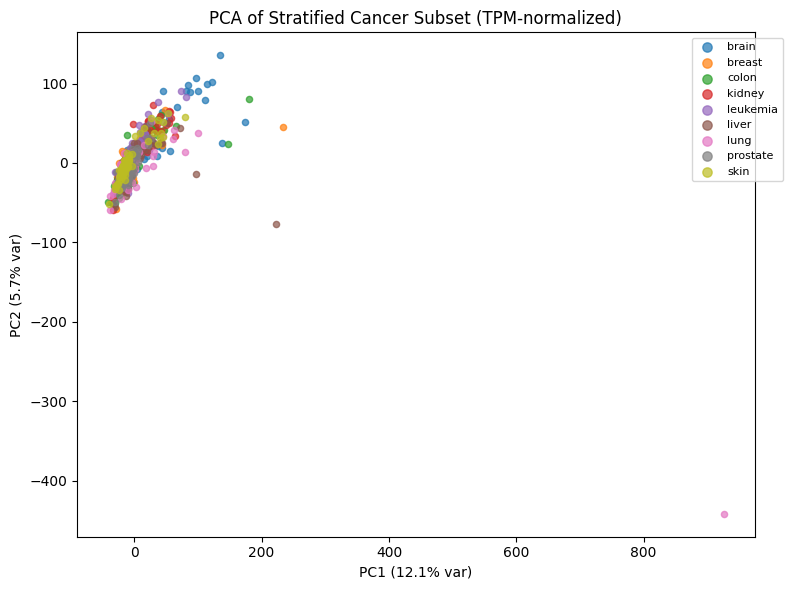

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# 1️⃣ LOAD FINAL DATASET
# -------------------------------------------------------------
file = "./data/archs4/cancer_subset_prebulk_tpm.h5"
expr = pd.read_hdf(file, key="expr")

print(f"✅ Loaded TPM matrix: {expr.shape[0]:,} genes × {expr.shape[1]:,} samples")

# -------------------------------------------------------------
# 2️⃣ LOAD SAMPLE LABELS (for coloring PCA)
# -------------------------------------------------------------
meta = pd.read_csv("./data/archs4/cancer_subset_samples.csv")
print("Sample label counts:\n", meta["label"].value_counts())

# Ensure columns and metadata are aligned
# Keep only GEOs that actually exist in the expression matrix
meta = meta[meta["geo"].isin(expr.columns)].reset_index(drop=True)

# Align expression matrix to filtered meta
expr = expr.loc[:, meta["geo"]]
print(f"Aligned: {expr.shape[1]} samples remain after matching metadata.")

# -------------------------------------------------------------
# 3️⃣ PREPARE MATRIX FOR PCA (samples as rows, genes as columns)
# -------------------------------------------------------------
X = expr.T.astype(np.float32)
print(f"PCA input shape: {X.shape}")

# Standardize
X_std = (X - X.mean()) / X.std()
X_std = X_std.fillna(0).to_numpy()   # <— key line to fix NaNs

# # -------------------------------------------------------------
# # 4️⃣ RUN PCA
# # -------------------------------------------------------------
# pca = PCA(n_components=2, random_state=42)
# pcs = pca.fit_transform(X_std)

# print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


# # -------------------------------------------------------------
# # 5️⃣ VISUALIZE
# # -------------------------------------------------------------
# plt.figure(figsize=(8,6))
# palette = dict(zip(sorted(meta["label"].unique()),
#                    sns.color_palette("tab10", len(meta["label"].unique()))))

# for label, color in palette.items():
#     idx = (meta["label"] == label)
#     plt.scatter(pcs[idx,0], pcs[idx,1], s=20, alpha=0.7, color=color, label=label)

# plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
# plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
# plt.title("PCA of Stratified Cancer Subset (TPM-normalized)")
# plt.legend(markerscale=1.5, fontsize=8, bbox_to_anchor=(1.05,1))
# plt.tight_layout()
# plt.show()


✅ Loaded: 19,478 genes × 641 samples
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 641 samples in 0.001s...
[t-SNE] Computed neighbors for 641 samples in 2.390s...
[t-SNE] Computed conditional probabilities for sample 641 / 641
[t-SNE] Mean sigma: 35.422627
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.799484
[t-SNE] KL divergence after 1000 iterations: 0.781207


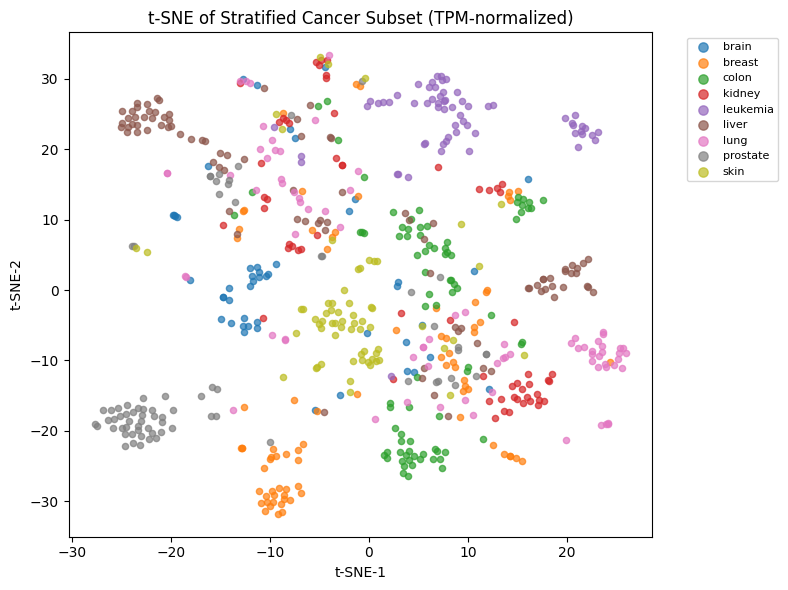

In [22]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# 1️⃣ LOAD DATA (already preprocessed)
# -------------------------------------------------------------
file = "./data/archs4/cancer_subset_prebulk_tpm.h5"
expr = pd.read_hdf(file, key="expr")

meta = pd.read_csv("./data/archs4/cancer_subset_samples.csv")
meta = meta[meta["geo"].isin(expr.columns)].reset_index(drop=True)
expr = expr.loc[:, meta["geo"]]

print(f"✅ Loaded: {expr.shape[0]:,} genes × {expr.shape[1]:,} samples")

# -------------------------------------------------------------
# 2️⃣ STANDARDIZE (mean=0, var=1)
# -------------------------------------------------------------
X = expr.T.astype(np.float32)
X_std = (X - X.mean()) / X.std()
X_std = X_std.fillna(0).to_numpy()

# -------------------------------------------------------------
# 3️⃣ DIMENSIONALITY REDUCTION (optional PCA → t-SNE)
# -------------------------------------------------------------
# t-SNE performs better if you reduce to ~50D first via PCA
from sklearn.decomposition import PCA

pca_50 = PCA(n_components=50, random_state=42)
X_pca = pca_50.fit_transform(X_std)

# -------------------------------------------------------------
# 4️⃣ RUN t-SNE
# -------------------------------------------------------------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,     # ✅ new parameter name
    random_state=42,
    init="pca",
    verbose=1
)

X_embedded = tsne.fit_transform(X_pca)

# -------------------------------------------------------------
# 5️⃣ VISUALIZE
# -------------------------------------------------------------
plt.figure(figsize=(8,6))
palette = dict(zip(sorted(meta["label"].unique()),
                   sns.color_palette("tab10", len(meta["label"].unique()))))

for label, color in palette.items():
    idx = (meta["label"] == label)
    plt.scatter(X_embedded[idx,0], X_embedded[idx,1],
                s=20, alpha=0.7, color=color, label=label)

plt.title("t-SNE of Stratified Cancer Subset (TPM-normalized)")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend(markerscale=1.5, fontsize=8, bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()


In [26]:
import os

file_path = "./data/archs4/cancer_subset_prebulk_tpm.h5"
size_bytes = os.path.getsize(file_path)
size_gb = size_bytes / (1024 ** 3)
print(f"📦 File size on disk: {size_gb:.2f} GB")


📦 File size on disk: 0.09 GB


In [ ]:
expr = pd.read_hdf(file, key="expr", start=0, stop=20000)


In [11]:
import os, re, h5py, numpy as np, pandas as pd
from Bio import SeqIO
import archs4py as a4

# ----------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------
file = "./data/archs4/human_gene_v2.5.h5"
protein_sequence_file = "./data/ensembl/Homo_sapiens.GRCh38.pep.all.fa"
output_h5 = "./data/archs4/cancer_prebulk_tpm.h5"
output_dir = "./data/archs4/"
os.makedirs(output_dir, exist_ok=True)

search_term = "cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma"
qc_min_nonzero = 14000  # PreBULK threshold
canonical_gene_count = 20010  # expected total protein-coding genes

# ----------------------------------------------------------------------
# 1️⃣ LOAD PROTEIN-CODING GENE ANNOTATIONS (ENSEMBL)
# ----------------------------------------------------------------------
print("📘 Parsing Ensembl FASTA for protein-coding genes...")
records = []
for rec in SeqIO.parse(protein_sequence_file, "fasta"):
    desc = rec.description
    parts = {}
    for token in desc.split():
        if ":" in token:
            k, v = token.split(":", 1)
            parts[k] = v
    if parts.get("gene_biotype") != "protein_coding":
        continue
    records.append({
        "gene_id": parts.get("gene"),
        "gene_symbol": parts.get("gene_symbol"),
        "seq": str(rec.seq),
        "length": len(rec.seq)
    })

genes_df = pd.DataFrame(records).drop_duplicates("gene_symbol")
print(f"✅ Extracted {genes_df.shape[0]:,} protein-coding genes")

# Create lookup for gene lengths
gene_lengths = genes_df.set_index("gene_symbol")["length"]

# ----------------------------------------------------------------------
# 2️⃣ LOAD CANCER EXPRESSION DATA FROM ARCHS4
# ----------------------------------------------------------------------
print(f"\n📊 Extracting samples matching: {search_term}")
expr = a4.data.meta(file, search_term, remove_sc=True)
print(f"Raw expression matrix: {expr.shape[0]:,} genes × {expr.shape[1]:,} samples")

# ----------------------------------------------------------------------
# 3️⃣ AGGREGATE DUPLICATE GENE SYMBOLS
# ----------------------------------------------------------------------
print("⚙️ Aggregating duplicate gene symbols...")
expr_agg = expr.groupby(expr.index).sum()
print(f"After aggregation: {expr_agg.shape[0]:,} unique genes")

# ----------------------------------------------------------------------
# 4️⃣ FILTER TO PROTEIN-CODING GENES ONLY
# ----------------------------------------------------------------------
expr_pc = expr_agg.loc[expr_agg.index.intersection(gene_lengths.index)]
print(f"Protein-coding subset: {expr_pc.shape[0]:,} genes × {expr_pc.shape[1]:,} samples")

# ----------------------------------------------------------------------
# 5️⃣ QUALITY CONTROL: REMOVE LOW-NONZERO SAMPLES
# ----------------------------------------------------------------------
nonzero_counts = (expr_pc > 0).sum(axis=0)
expr_qc = expr_pc.loc[:, nonzero_counts >= qc_min_nonzero]
removed = expr_pc.shape[1] - expr_qc.shape[1]
print(f"QC filter removed {removed:,} samples with < {qc_min_nonzero} nonzero genes")
print(f"Retained {expr_qc.shape[1]:,} samples after QC")

# ----------------------------------------------------------------------
# 6️⃣ TPM NORMALIZATION
# ----------------------------------------------------------------------
print("⚙️ Converting counts → TPM ...")
lengths = gene_lengths.loc[expr_qc.index].fillna(1)

def counts_to_tpm(counts: pd.DataFrame, lengths: pd.Series) -> pd.DataFrame:
    rate = counts.div(lengths, axis=0)
    denom = rate.sum(axis=0)
    return rate.div(denom, axis=1) * 1e6

expr_tpm = counts_to_tpm(expr_qc, lengths)
print(f"TPM-normalized matrix: {expr_tpm.shape}")

# ----------------------------------------------------------------------
# 7️⃣ REINDEX TO FULL CANONICAL GENE SET (ZERO-PADDING)
# ----------------------------------------------------------------------
print("🧩 Aligning to full canonical 20k gene list with zero-padding...")
canonical_genes = genes_df["gene_symbol"].tolist()
expr_final = expr_tpm.reindex(canonical_genes, fill_value=0)
print(f"Aligned matrix shape: {expr_final.shape}")

# ----------------------------------------------------------------------
# 8️⃣ SAVE FINAL DATASET
# ----------------------------------------------------------------------
print(f"💾 Saving dataset to: {output_h5}")
expr_final.to_hdf(output_h5, key="expr", mode="w")
expr_final.columns.to_series().to_csv(os.path.join(output_dir, "cancer_prebulk_samples.txt"), index=False)
pd.Series(canonical_genes, name="gene_symbol").to_csv(os.path.join(output_dir, "canonical_genes.txt"), index=False)

print("\n✅ PreBULK-style preprocessing complete!")
print(f"→ {expr_final.shape[0]:,} genes × {expr_final.shape[1]:,} samples saved")


📘 Parsing Ensembl FASTA for protein-coding genes...
✅ Extracted 19,478 protein-coding genes

📊 Extracting samples matching: cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma
Searches for any occurrence of cancer|tumor|carcinoma|leukemia|lymphoma|melanoma|glioma as regular expression


100%|██████████| 147372/147372 [07:50<00:00, 313.01it/s]


MemoryError: Unable to allocate 36.9 GiB for an array with shape (67186, 147372) and data type uint32

In [30]:
import pandas as pd

# 1️⃣ Basic summary
genes = expr.index.to_series()
print("Total rows (genes):", len(genes))
print("Unique gene names:", genes.nunique())

# 2️⃣ Find duplicate symbols
dup_counts = genes.value_counts()
duplicates = dup_counts[dup_counts > 1]
print(f"Duplicate gene symbols: {len(duplicates)} ({len(duplicates)/len(dup_counts)*100:.2f}%)")

# 3️⃣ Show examples of duplicated symbols
print("\nExamples of duplicates:")
print(duplicates.head(10))

# 4️⃣ Look at naming patterns
import re

patterns = {
    "pseudogene": genes.str.contains("P", regex=False).sum(),
    "mt_": genes.str.contains("^MT-", case=False, regex=True).sum(),
    "RP11_": genes.str.contains("^RP11", case=False, regex=True).sum(),
    "LOC_": genes.str.contains("^LOC", case=False, regex=True).sum(),
    "LINC_": genes.str.contains("^LINC", case=False, regex=True).sum(),
}

print("\nNaming pattern counts:")
for k,v in patterns.items():
    print(f"{k:<12}: {v:,}")

# 5️⃣ See sample gene names for a feel
print("\nRandom sample of 15 gene names:")
print(genes.sample(15, random_state=42).tolist())


Total rows (genes): 21945
Unique gene names: 19243
Duplicate gene symbols: 1196 (6.22%)

Examples of duplicates:
KIR3DL2    43
KIR3DL3    42
KIR2DL4    41
KIR3DP1    35
KIR2DL1    33
KIR3DL1    32
KIR2DS4    32
KIR2DL3    31
KIR2DP1    30
NCR1       16
Name: count, dtype: int64

Naming pattern counts:
pseudogene  : 6,459
mt_         : 13
RP11_       : 0
LOC_        : 0
LINC_       : 12

Random sample of 15 gene names:
['APOA1', 'MAD2L1', 'F2RL3', 'UBE2A', 'ABR', 'ADAMTS5', 'PPP1R10', 'CACNA1G', 'IYD', 'RPL36AL', 'TRIM54', 'ADCY8', 'FLOT1', 'TBATA', 'GUCY1B1']


In [20]:
import h5py, numpy as np, pandas as pd, time


with h5py.File(file, "r") as f:
    n_genes, n_samples = f["data"]["expression"].shape
    print(f"Matrix: {n_genes} genes × {n_samples} samples")

    def clean_series_id(s):
        s = s.strip()
        if ',' in s:
            s = s.split(',')[0]
        return s

    series_ids = np.array([clean_series_id(s.decode("ascii", "ignore")) for s in f["meta"]["samples"]["series_id"][:n_samples]])
    geo_accessions = np.array([s.decode("ascii", "ignore") for s in f["meta"]["samples"]["geo_accession"][:n_samples]])

    expr = f["data"]["expression"]

    # count valid samples per GSE
    unique_series, counts = np.unique(series_ids, return_counts=True)
    series_GSE_and_sample_count = pd.Series(counts, index=unique_series).sort_values(ascending=False)

df_stat = []
mask = (series_GSE_and_sample_count > 10) & (series_GSE_and_sample_count < 2_000_000)

t0 = time.time()
for GSE in series_GSE_and_sample_count[mask].index[:15]:
    with h5py.File(file, "r") as f:
        all_series = np.array([clean_series_id(s.decode("ascii", "ignore")) for s in f["meta"]["samples"]["series_id"][:n_samples]])
        idx = np.where(all_series == GSE)[0]
        if len(idx) == 0:
            continue  # skip invalid

        X_subset = f["data"]["expression"][:, idx]

        n_genes, n_samples = X_subset.shape
        zero_genes = (X_subset.sum(axis=1) == 0).sum()
        nz_genes = n_genes - zero_genes
        zeros_percent = np.round((X_subset[:] == 0).sum() / (n_genes * n_samples) * 100, 2)

        df_stat.append({
            "GSE": GSE,
            "Sample count": n_samples,
            "Non-zero genes": nz_genes,
            "% zeros": zeros_percent
        })

df_stat = pd.DataFrame(df_stat)
print(f"Completed in {np.round(time.time() - t0, 1)} s")
df_stat.head(10)


Matrix: 67186 genes × 888821 samples
Completed in 25.6 s
Completed in 25.6 s


,GSE,Sample count,Non-zero genes,% zeros
0,GSE116672,13126,64351,94.02


In [3]:
meta = a4.meta.meta(file, "cancer", meta_fields=["geo_accession", "source_name_ch1", "characteristics_ch1", "title"])
meta.head()


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]



,geo_accession,source_name_ch1,characteristics_ch1,title
GSM1019735,GSM1019735,HT29 treated with 0 Î¼M of 5-Aza,"cell line: HT29,cell type: colon cancer,treatm...","HT29 at 0 Î¼M of 5-Aza, biological rep1"
GSM1019736,GSM1019736,HT29 treated with 0 Î¼M of 5-Aza,"cell line: HT29,cell type: colon cancer,treatm...","HT29 at 0 Î¼M of 5-Aza, biological rep2"
GSM1019737,GSM1019737,HT29 treated with 0 Î¼M of 5-Aza,"cell line: HT29,cell type: colon cancer,treatm...","HT29 at 0 Î¼M of 5-Aza, biological rep3"
GSM1019738,GSM1019738,HT29 treated with 5 Î¼M of 5-Aza,"cell line: HT29,cell type: colon cancer,treatm...","HT29 at 5 Î¼M of 5-Aza, biological rep1"
GSM1019739,GSM1019739,HT29 treated with 5 Î¼M of 5-Aza,"cell line: HT29,cell type: colon cancer,treatm...","HT29 at 5 Î¼M of 5-Aza, biological rep2"


In [ ]:
cancer_meta = meta[meta["source_name_ch1"].str.contains("breast|lung|colon", case=False, na=False)]
cancer_types = cancer_meta["source_name_ch1"].unique()
print(cancer_types)

['breast cancer cells' 'breast cancer MCF7 cells'
 'Immortalized human breast cancer cells' 'Breast cancer cells'
 'breast cancer cell line' 'Breast cancer cell line'
 'breast cancer cell line clone, WT RBM47, 0 ng/ml doxycycline'
 'breast cancer cell line clone, WT RBM47, 1 ng/ml doxycycline'
 'breast cancer cell line clone, WT RBM47, 2.5 ng/ml doxycycline'
 'breast cancer cell line clone, WT RBM47, 5 ng/ml doxycycline'
 'breast cancer cell line clone, WT RBM47, 25 ng/ml doxycycline'
 'breast cancer cell line clone, RBM47-I281fs mutant, 0 ng/ml doxycycline'
 'breast cancer cell line clone, RBM47-I281fs mutant, 1 ng/ml doxycycline'
 'breast cancer cell line clone, RBM47-I281fs mutant, 2.5 ng/ml doxycycline'
 'breast cancer cell line clone, RBM47-I281fs mutant, 5 ng/ml doxycycline'
 'breast cancer cell line clone, RBM47-I281fs mutant, 25 ng/ml doxycycline'
 'Colon cancer cell line' 'breast cancer cancer cell line, control'
 'breast cancer cancer cell line, over-expressing miR-424'
 'Bre

In [6]:
cancer_types.shape

(715,)

In [7]:
import pandas as pd
import re

def clean_label(x):
    x = x.lower()
    # remove punctuation and underscores
    x = re.sub(r"[_\-]", " ", x)
    # collapse whitespace
    x = re.sub(r"\s+", " ", x)
    return x.strip()

cancer_meta["clean_label"] = cancer_meta["source_name_ch1"].apply(clean_label)

def coarse_group(x):
    if re.search(r"breast", x): return "breast"
    if re.search(r"lung", x):   return "lung"
    if re.search(r"colon|colorectal|hct116", x): return "colon"
    if re.search(r"prostate", x): return "prostate"
    if re.search(r"ovarian|ovary", x): return "ovarian"
    if re.search(r"melanoma|skin", x): return "melanoma"
    if re.search(r"glioma|brain|astro", x): return "brain"
    if re.search(r"leukemia|lymphoma", x): return "hematologic"
    if re.search(r"renal|kidney", x): return "renal"
    return "other"

cancer_meta["group"] = cancer_meta["clean_label"].apply(coarse_group)

cancer_meta["group"].value_counts()


C:\Users\walt\AppData\Local\Temp\ipykernel_25176\4011744914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_meta["clean_label"] = cancer_meta["source_name_ch1"].apply(clean_label)
C:\Users\walt\AppData\Local\Temp\ipykernel_25176\4011744914.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_meta["group"] = cancer_meta["clean_label"].apply(coarse_group)


group
breast    12225
lung       6896
colon      1517
Name: count, dtype: int64

100%|██████████| 8413/8413 [00:19<00:00, 435.90it/s]

100%|██████████| 12225/12225 [00:24<00:00, 499.71it/s]



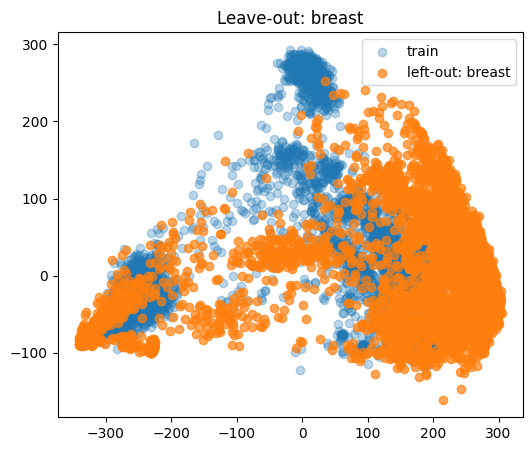

100%|██████████| 19121/19121 [00:44<00:00, 431.64it/s]

100%|██████████| 1517/1517 [00:06<00:00, 250.30it/s]



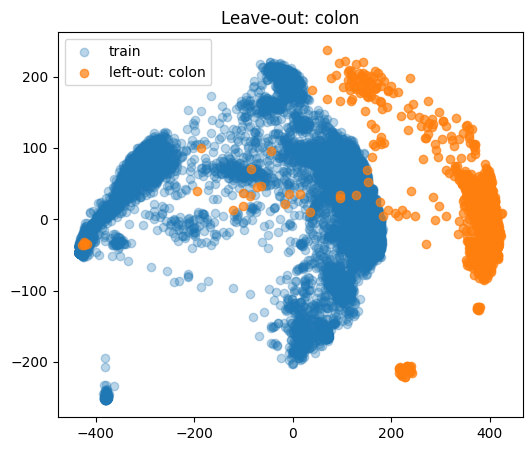

100%|██████████| 13742/13742 [00:26<00:00, 524.63it/s]

100%|██████████| 6896/6896 [00:14<00:00, 477.06it/s]



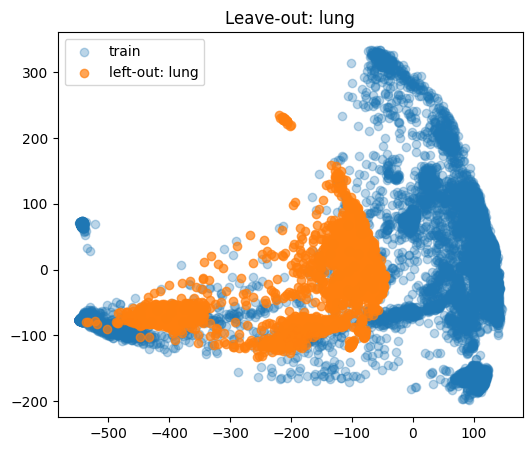

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

cancer_types = cancer_meta["group"].unique()
for leave_out in cancer_types:
    train_samples = cancer_meta[cancer_meta["group"] != leave_out]
    test_samples  = cancer_meta[cancer_meta["group"] == leave_out]
    
    train_expr = a4.data.samples(file, list(train_samples["geo_accession"]))
    test_expr  = a4.data.samples(file, list(test_samples["geo_accession"]))

    # normalize
    train_expr = a4.normalize(train_expr, method="log_quantile")
    test_expr  = a4.normalize(test_expr, method="log_quantile")

    # simple “embedding model” example — PCA
    pca = PCA(n_components=2)
    emb_train = pca.fit_transform(train_expr.T)
    emb_test  = pca.transform(test_expr.T)

    plt.figure(figsize=(6,5))
    plt.scatter(emb_train[:,0], emb_train[:,1], alpha=0.3, label="train")
    plt.scatter(emb_test[:,0],  emb_test[:,1],  alpha=0.7, label=f"left-out: {leave_out}")
    plt.legend()
    plt.title(f"Leave-out: {leave_out}")
    plt.show()

In [14]:
selected_samples = list(cancer_meta["geo_accession"])
expr = a4.data.samples(file, selected_samples)


100%|██████████| 20638/20638 [00:36<00:00, 557.92it/s]



In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

for leave_out in cancer_types:
    train_samples = cancer_meta[~cancer_meta["source_name_ch1"].str.contains(leave_out, case=False)]
    test_samples  = cancer_meta[cancer_meta["source_name_ch1"].str.contains(leave_out, case=False)]

    train_expr = a4.data.samples(file, list(train_samples["geo_accession"]))
    test_expr  = a4.data.samples(file, list(test_samples["geo_accession"]))

    # normalize
    train_expr = a4.normalize(train_expr, method="log_quantile")
    test_expr  = a4.normalize(test_expr, method="log_quantile")

    # simple “embedding model” example — PCA
    pca = PCA(n_components=2)
    emb_train = pca.fit_transform(train_expr.T)
    emb_test  = pca.transform(test_expr.T)

    plt.figure(figsize=(6,5))
    plt.scatter(emb_train[:,0], emb_train[:,1], alpha=0.3, label="train")
    plt.scatter(emb_test[:,0],  emb_test[:,1],  alpha=0.7, label=f"left-out: {leave_out}")
    plt.legend()
    plt.title(f"Leave-out: {leave_out}")
    plt.show()


100%|██████████| 18851/18851 [00:34<00:00, 552.08it/s]

100%|██████████| 1787/1787 [00:05<00:00, 329.21it/s]

